In [1]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Paths 
keywords_path = r"E:\Coding\BDA-PySpark\realtime-pipeline\results_spark\keywords_spark.csv"
topics_path = r"E:\Coding\BDA-PySpark\realtime-pipeline\results_spark\topic_results_spark.csv"

# Load CSVs 
keywords_df = pd.read_csv(keywords_path)
topics_df = pd.read_csv(topics_path)

print(f"[INFO] Loaded dataframes:")
print(f"Keywords: {keywords_df.shape}")
print(f"Topics: {topics_df.shape}")

# Merge 
merged_df = topics_df.copy()
merged_df["keywords"] = keywords_df["keywords"]

# Group keywords per topic 
topic_groups = (
    merged_df.groupby("topic")["keywords"]
    .apply(lambda x: ", ".join(x.dropna().astype(str)))
    .reset_index()
)

print(f"[DEBUG] topic_groups shape: {topic_groups.shape}\n")

[INFO] Loaded dataframes:
Keywords: (133, 2)
Topics: (148, 3)
[DEBUG] topic_groups shape: (5, 2)



In [2]:
category_labels = [
    "Politics and Government",
    "Law and Justice",
    "Business and Economy",
    "Technology and Gadgets",
    "Science and Innovation",
    "Environment and Climate",
    "Health and Medicine",
    "Mental Health and Wellbeing",
    "Education and Learning",
    "Work and Careers",
    "Sports and Fitness",
    "Gaming and Esports",
    "Movies and TV Shows",
    "Music and Entertainment",
    "Art and Creativity",
    "Religion and Spirituality",
    "Philosophy and Ethics",
    "Relationships and Dating",
    "Parenting and Family Life",
    "Food and Cooking",
    "Travel and Adventure",
    "Internet Culture and Memes",
    "History and Society",
    "Animals and Nature",
    "Fashion and Lifestyle"
]


[INFO] Loading embedding model...
[INFO] Using device: cpu

[TOPIC 0] Filtered Keywords:
clear onsetting event stress level started running sleep quality hit massi absolute shit work rhr pr ms, angles played downfield pursuit logic ignored significan highlight stick yes added game unless game added saw problem, completely understandable gi true talent rarely gi proper classestraining girls regressed gi seasons nia girls ven, nsfw ai chat enjoy rpussyperfectionx pussy perfection radorablenudes adorable nudes discord fuckdoll paradise rsexybutclothed sexy girls rchaturbatecam chaturbate li best girls vesexwebcams share rthickthighs girl rlushsexstories lovers, jos current politics youve forgotten playfully mean harry potter frankly mean ya ti spirited spew realize, uterine pain getting info ask condescendingly vaginally push poop push wrote ultrasound stressed pri, home owner relati liability associated generating equity condo market edmonton stagnant renter place massi markets

[TOPIC 1

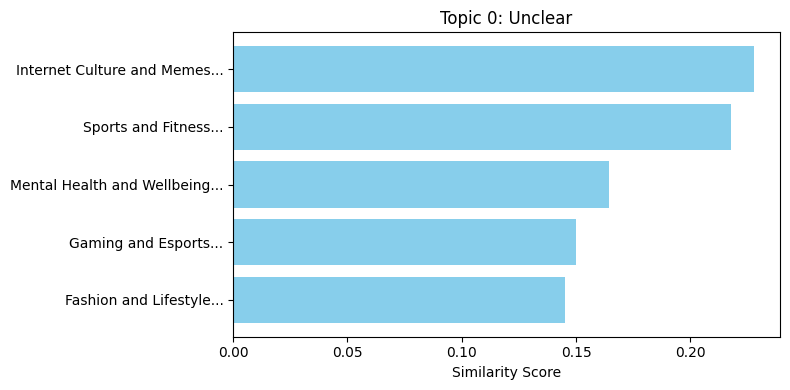


Topic 1 →
   ↳ Assigned Label: Internet Culture and Memes
   ↳ Top Matches:
      Internet Culture and Memes                                   : 0.408
      Gaming and Esports                                           : 0.260
      Music and Entertainment                                      : 0.160
      Politics and Government                                      : 0.144
      Travel and Adventure                                         : 0.137
--------------------------------------------------------------------------------


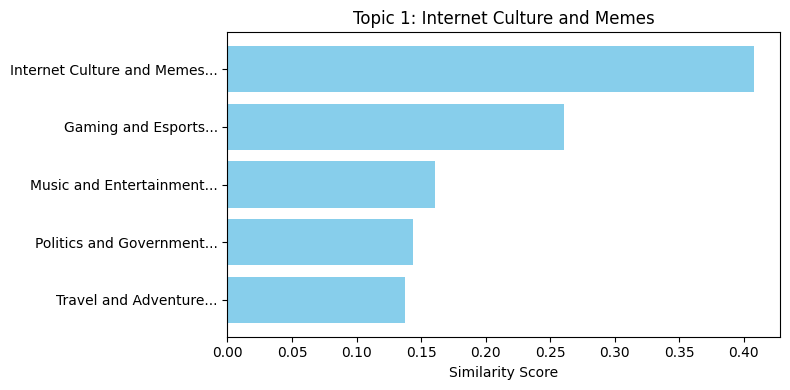


Topic 2 →
   ↳ Assigned Label: Unclear
   ↳ Top Matches:
      Animals and Nature                                           : 0.214
      Travel and Adventure                                         : 0.177
      Mental Health and Wellbeing                                  : 0.176
      Philosophy and Ethics                                        : 0.163
      Law and Justice                                              : 0.151
--------------------------------------------------------------------------------


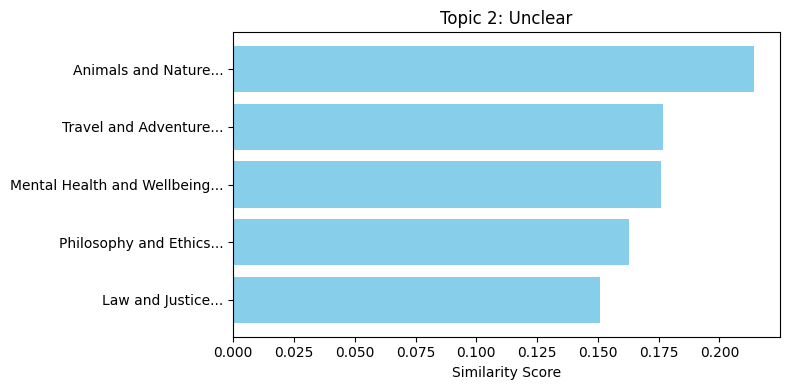


Topic 3 →
   ↳ Assigned Label: Unclear
   ↳ Top Matches:
      Movies and TV Shows                                          : 0.278
      Gaming and Esports                                           : 0.263
      Relationships and Dating                                     : 0.258
      Internet Culture and Memes                                   : 0.241
      Mental Health and Wellbeing                                  : 0.195
--------------------------------------------------------------------------------


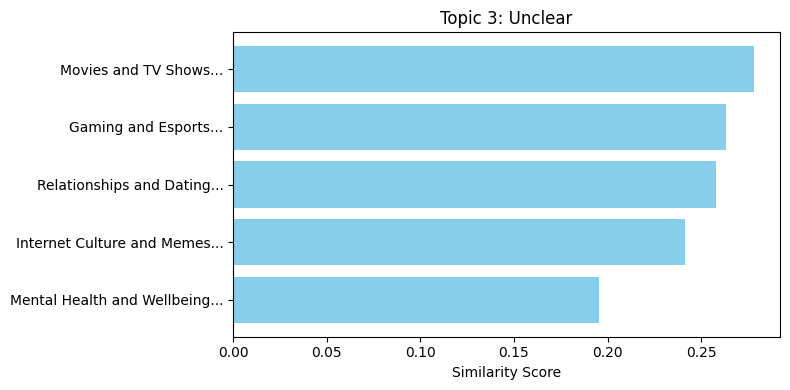


Topic 4 →
   ↳ Assigned Label: Unclear
   ↳ Top Matches:
      Internet Culture and Memes                                   : 0.284
      Art and Creativity                                           : 0.214
      Travel and Adventure                                         : 0.192
      Philosophy and Ethics                                        : 0.182
      Law and Justice                                              : 0.179
--------------------------------------------------------------------------------


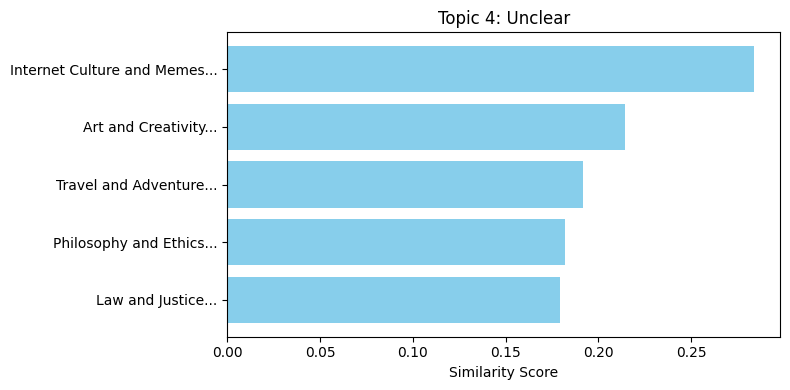

In [3]:
#Load model
print("[INFO] Loading embedding model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)
print(f"[INFO] Using device: {device}")

# Encode category labels 
category_embeddings = model.encode(category_labels, convert_to_tensor=True, device=device)

topic_texts = []
for _, row in topic_groups.iterrows():
    keywords = [k.strip() for k in row["keywords"].split(",") if k.strip()]
    keywords = [k for k in keywords if len(k) >= 3]  

    unique_keywords = list(dict.fromkeys(keywords))  
    top_keywords = unique_keywords[:10]  

    topic_text = " ".join(top_keywords)
    topic_texts.append(topic_text)

    print(f"\n[TOPIC {row['topic']}] Filtered Keywords:")
    print(", ".join(top_keywords))

# Encode all topics at once 
print("\n[INFO] Encoding topic clusters...")
topic_embeddings = model.encode(topic_texts, convert_to_tensor=True, device=device, batch_size=8)

# Compute similarity & assign labels 
print("\n[INFO] Processing topics...\n")
assigned_labels = []

for i, topic_embedding in enumerate(topic_embeddings):
    similarities = util.cos_sim(topic_embedding, category_embeddings)[0]
    similarities_np = similarities.cpu().numpy()

    top_indices = similarities_np.argsort()[-5:][::-1]
    top_labels = [category_labels[j] for j in top_indices]
    top_scores = similarities_np[top_indices]

    if top_scores[0] < 0.30 or (top_scores[0] - top_scores[1]) < 0.05:
        best_label = "Unclear"
    else:
        best_label = top_labels[0]

    assigned_labels.append(best_label)

    # Print results
    print(f"\nTopic {topic_groups.loc[i, 'topic']} →")
    print(f"   ↳ Assigned Label: {best_label}")
    print(f"   ↳ Top Matches:")
    for lbl, sc in zip(top_labels, top_scores):
        print(f"      {lbl[:60]:<60} : {sc:.3f}")
    print("-" * 80)

    # Visualization 
    plt.figure(figsize=(8, 4))
    plt.barh(range(len(top_labels)), top_scores[::-1], color='skyblue')
    plt.yticks(range(len(top_labels)), [l[:50] + "..." for l in top_labels[::-1]])
    plt.title(f"Topic {topic_groups.loc[i, 'topic']}: {best_label}")
    plt.xlabel("Similarity Score")
    plt.tight_layout()
    plt.show()